In [1]:
import numpy as np
import pandas as pd

data = "/mnt/d/Data/Instacart/"

In [2]:
train = pd.read_csv(data+"train.tsv", sep='\t', dtype={
    'order_id': np.int32,
    'user_id': np.int32,
    'product_id': np.uint16,
    'label': np.int8,
    'seed': np.int8
})

valid = train[train['seed']>=3].drop('seed', axis=1)
train = train[train['seed']<3].drop('seed', axis=1)

f = pd.read_hdf("/mnt/d/Data/Instacart/dataset.hdf", "train")

In [3]:
f.head()

,order_id,user_id,product_id,label,seed,second_order_ratio,avg_reorder_ratio,user_reorder_ratio,days_since_prior_order,user_product_order_cnt,user_prod_order_rate,user_prod_last_vacancy,user_prod_order_freq
0,1187899,1,196,1,3,0.582500,4.473875,0.759259,14.0,10,1.0,1,1.0
1,1187899,1,14084,0,1,0.629150,5.290505,0.759259,14.0,1,0.1,10,1.0
2,1187899,1,12427,0,3,0.529482,3.857058,0.759259,14.0,10,1.0,1,1.0
3,1187899,1,26088,1,2,0.404987,2.169390,0.759259,14.0,2,0.2,9,1.0
4,1187899,1,26405,1,0,0.362832,1.790560,0.759259,14.0,2,0.2,7,0.5


In [3]:
train = f[f['seed']>=3].drop(['order_id', 'user_id', 'product_id', 'seed'], axis=1)
valid = f[f['seed']<3].drop(['order_id', 'user_id', 'product_id', 'seed'], axis=1)

del f

In [5]:
train.head()

,label,second_order_ratio,avg_reorder_ratio,user_reorder_ratio,days_since_prior_order,user_product_order_cnt,user_prod_order_rate,user_prod_last_vacancy,user_prod_order_freq
0,1,0.582500,4.473875,0.759259,14.0,10,1.0,1,1.0
2,0,0.529482,3.857058,0.759259,14.0,10,1.0,1,1.0
11,0,0.527426,3.082390,0.759259,14.0,1,0.1,6,1.0
12,0,0.495725,2.856348,0.759259,14.0,1,0.1,6,1.0
15,1,0.634271,4.278772,0.759259,14.0,1,0.1,1,1.0


<hr/>

Training using lightgbm

In [4]:
import lightgbm as lgb

X = lgb.Dataset(train.drop('label', axis=1), train['label'])
V = lgb.Dataset(valid.drop('label', axis=1), valid['label'], reference=X)

In [9]:
from sklearn.metrics import f1_score


TH = 0.25

def f1(preds, train_data):
    Yt = train_data.get_label()
    return 'f1', f1_score(Yt, preds>TH), True

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}

In [11]:
gbdt = lgb.train(params, X, valid_sets=V, feval=f1)

[1]	valid_0's auc: 0.821201	valid_0's f1: 0.177841
[2]	valid_0's auc: 0.823747	valid_0's f1: 0.177841
[3]	valid_0's auc: 0.824499	valid_0's f1: 0.177841
[4]	valid_0's auc: 0.825019	valid_0's f1: 0.177841
[5]	valid_0's auc: 0.825177	valid_0's f1: 0.177841
[6]	valid_0's auc: 0.826189	valid_0's f1: 0.177841
[7]	valid_0's auc: 0.826609	valid_0's f1: 0.200357
[8]	valid_0's auc: 0.827384	valid_0's f1: 0.298199
[9]	valid_0's auc: 0.827624	valid_0's f1: 0.354789
[10]	valid_0's auc: 0.82777	valid_0's f1: 0.388892
[11]	valid_0's auc: 0.82791	valid_0's f1: 0.40748
[12]	valid_0's auc: 0.828228	valid_0's f1: 0.420129
[13]	valid_0's auc: 0.828391	valid_0's f1: 0.42693
[14]	valid_0's auc: 0.82845	valid_0's f1: 0.431601
[15]	valid_0's auc: 0.828746	valid_0's f1: 0.434769
[16]	valid_0's auc: 0.828825	valid_0's f1: 0.436533
[17]	valid_0's auc: 0.828996	valid_0's f1: 0.43747
[18]	valid_0's auc: 0.828972	valid_0's f1: 0.437828
[19]	valid_0's auc: 0.829357	valid_0's f1: 0.43837
[20]	valid_0's auc: 0.82926	

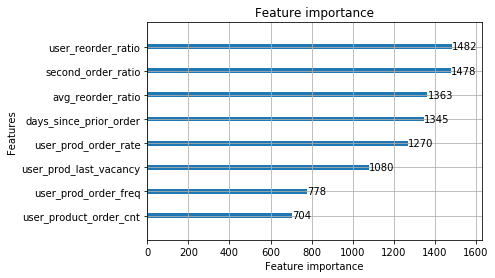

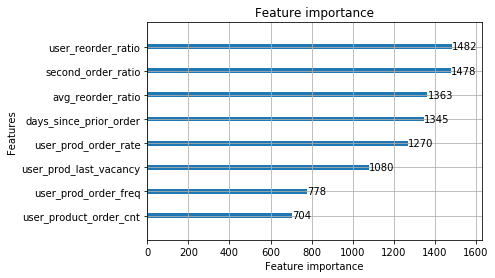

In [14]:
import matplotlib.pyplot as plt

ax = lgb.plot_importance(gbdt)
plt.show()

<hr/>

predict and submit

In [7]:
test = pd.read_hdf("/mnt/d/Data/Instacart/dataset.hdf", "test")

In [8]:
train = train.append(valid)

In [9]:
import lightgbm as lgb

X = lgb.Dataset(train.drop('label', axis=1), train['label'])


In [10]:
gbdt = lgb.train(params, X, )

In [12]:
Y = gbdt.predict(test.drop(['order_id', 'user_id', 'product_id'], axis=1))

In [13]:
Y

array([ 0.13590789,  0.31685861,  0.02632793, ...,  0.08506892,
        0.5907455 ,  0.92965552])

In [26]:
test['label'] = Y>0.25

In [22]:
Y>0.5

array([False, False, False, ..., False,  True,  True], dtype=bool)

In [19]:
test.head()

,order_id,user_id,product_id,second_order_ratio,avg_reorder_ratio,user_reorder_ratio,days_since_prior_order,user_product_order_cnt,user_prod_order_rate,user_prod_last_vacancy,user_prod_order_freq,label
0,2774568,3,9387,0.469170,2.860632,0.705128,11.0,5,0.416667,6,0.714286,False
1,2774568,3,17668,0.383146,2.370787,0.705128,11.0,5,0.416667,2,0.454545,True
2,2774568,3,15143,0.358081,1.968589,0.705128,11.0,1,0.083333,12,1.000000,False
3,2774568,3,16797,0.566618,3.312962,0.705128,11.0,3,0.250000,4,0.333333,False
4,2774568,3,39190,0.430526,2.345447,0.705128,11.0,10,0.833333,1,0.833333,True


In [27]:
d = dict()
for row in test.itertuples():
    if row.label:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test.order_id:
    if order not in d:
        d[order] = 'None'

In [28]:
sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('result_025.csv', index=False)

In [21]:
train

,label,second_order_ratio,avg_reorder_ratio,user_reorder_ratio,days_since_prior_order,user_product_order_cnt,user_prod_order_rate,user_prod_last_vacancy,user_prod_order_freq
0,1,0.582500,4.473875,0.759259,14.0,10,1.000000,1,1.000000
2,0,0.529482,3.857058,0.759259,14.0,10,1.000000,1,1.000000
11,0,0.527426,3.082390,0.759259,14.0,1,0.100000,6,1.000000
12,0,0.495725,2.856348,0.759259,14.0,1,0.100000,6,1.000000
15,1,0.634271,4.278772,0.759259,14.0,1,0.100000,1,1.000000
18,0,0.582500,4.473875,0.515000,28.0,1,0.030303,24,1.000000
24,0,0.543279,3.699053,0.515000,28.0,5,0.151515,1,0.172414
26,0,0.487881,3.049811,0.515000,28.0,1,0.030303,13,1.000000
29,0,0.557770,3.134867,0.515000,28.0,1,0.030303,24,1.000000
30,0,0.564679,4.197768,0.515000,28.0,3,0.090909,6,0.230769
